### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
#import questionary   #Tried to include this and didn't work
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
#chaim edit 11/3/21 
from pathlib import Path
import csv
%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

    



To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 1000000


In [4]:
#portfolio_value = 1000000 #we assume client gives us 1mm to start with.

In [5]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    print("Thank you for your response!  You are a conversative investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    tickers = ["FB","AAPL","TSLA","RDS.A","GS"]
    print("Thank you for your response!  You are an aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Facebook, Apple, Tesla, Shell Oil, Goldman Sachs
elif int(risk_tolerance) == 3:
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    print("Thank you for your response!  You are a very aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string



    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  1


Thank you for your response!  You are a conversative investor.
The stocks in your portfolio will be ['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']


In [6]:
#Changed 2021-11-02 by Paul Lopez. We are running all time horizon scenarios to show the client the confidence intervals
# for 5, 10, and 20yrs and will output it to a CSV file if the client wants. Chaim's idea. You are welcome.

#time_horizon = input("Please select your time horizon for the forecast: 5, 10, or 20 years?")
#print(f"Thank you for your input! Your holding period will be {time_horizon} years")
#time_horizon = int(time_horizon) #forcing it to be an int
#chaim edit- changed print function to simplify output
#type if statement here if time_horizon is not 5, 10, or 20 we prompt the user to try again

In [7]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [8]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
#We can possibly make this start and end date a bit more dynamic by just pulling today's or yesterday's
#date and feeding in here as a variable.

In [9]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


BNDX                                  GOOGL        \
                            open   high    low  close   volume     open  high   
time                                                                            
2021-10-27 00:00:00-04:00  56.92  57.01  56.84  56.98  1965028  2790.15  2973   

                                                     ...    PZA               \
                              low    close   volume  ...   open  high    low   
time                                                 ...                       
2021-10-27 00:00:00-04:00  2788.1  2924.35  3772034  ...  26.75  26.8  26.75   

                                           VTEB                                
                           close  volume   open   high    low  close   volume  
time                                                                           
2021-10-27 00:00:00-04:00  26.78  336762  54.59  54.64  54.57  54.64  1398975  

[1 rows x 25 columns]

In [10]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

#fb_close_price = float(prices_df["FB"]["close"])
#aapl_close_price = float(prices_df["AAPL"]["close"])
#tsla_close_price = float(prices_df["TSLA"]["close"])
#rdsa_close_price = float(prices_df["RDS.A"]["close"])
#gs_close_price = float(prices_df["GS"]["close"])

# Print the AGG closing price
#display(fb_close_price)
#display(aapl_close_price)
#display(tsla_close_price)
#display(rdsa_close_price)
#display(gs_close_price)


167.83

54.64

26.78

56.98

2924.35

In [11]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
value_per_share = portfolio_value/5 #we assume 1 million dollar investment, and 200k per share.
stock1_shares = value_per_share / stock1_close_price
stock2_shares = value_per_share / stock2_close_price
stock3_shares = value_per_share / stock3_close_price
stock4_shares = value_per_share / stock4_close_price
stock5_shares = value_per_share / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_per_share:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


With $200000.00 you will be able to purchase 1192 shares of JPM.
With $200000.00 you will be able to purchase 3660 shares of VTEB.
With $200000.00 you will be able to purchase 7468 shares of PZA.
With $200000.00 you will be able to purchase 3510 shares of BNDX.
With $200000.00 you will be able to purchase 68 shares of GOOGL.


In [12]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
start_date = pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

limit_rows = 1000

In [13]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

BNDX                                GOOGL       \
                            open   high    low  close    volume  open high   
time                                                                         
2017-11-06 00:00:00-05:00    NaN    NaN    NaN    NaN       NaN   NaN  NaN   
2017-11-07 00:00:00-05:00  55.08  55.13  55.06  55.12  452318.0   NaN  NaN   

                                            ...    PZA                        \
                          low close volume  ...   open    high    low  close   
time                                        ...                                
2017-11-06 00:00:00-05:00 NaN   NaN    NaN  ...  25.66  25.700  25.63  25.68   
2017-11-07 00:00:00-05:00 NaN   NaN    NaN  ...  25.72  25.755  25.70  25.75   

                                    VTEB                        
                             volume open high low close volume  
time                                                            
2017-11-06 00:00:00-05:00  250797.0  NaN  NaN NaN   NaN    NaN  
2017-11-07 00:00:00-05:00  588297.0  NaN  NaN NaN   NaN    NaN  

[2 rows x 25 columns]

BNDX                                     GOOGL  \
                            open    high    low  close     volume     open   
time                                                                         
2021-10-27 00:00:00-04:00  56.92  57.010  56.84  56.98  1917349.0  2790.15   
2021-10-28 00:00:00-04:00  56.87  56.935  56.79  56.84  2496708.0  2942.69   

                                                                  ...    PZA  \
                              high       low    close     volume  ...   open   
time                                                              ...          
2021-10-27 00:00:00-04:00  2973.00  2788.100  2924.35  3765961.0  ...  26.75   
2021-10-28 00:00:00-04:00  2943.16  2892.535  2916.98  1597494.0  ...  26.81   

                                                           VTEB         \
                            high    low  close    volume   open   high   
time                                                                     
2021-10-27 00:00:00-04:00  26.80  26.75  26.78  335020.0  54.59  54.64   
2021-10-28 00:00:00-04:00  26.82  26.79  26.79  266175.0  54.62  54.64   

                                                      
                               low  close     volume  
time                                                  
2021-10-27 00:00:00-04:00  54.5700  54.64  1389010.0  
2021-10-28 00:00:00-04:00  54.5943  54.63  1011692.0  

[2 rows x 25 columns]

['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']

###Here we run a Monte Carlo simulation of 1000 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [14]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


BNDX                                    \
                            open     high    low   close    volume   
time                                                                 
2017-11-06 00:00:00-05:00    NaN      NaN    NaN     NaN       NaN   
2017-11-07 00:00:00-05:00  55.08  55.1300  55.06  55.120  452318.0   
2017-11-08 00:00:00-05:00  55.15  55.1800  55.07  55.075  636032.0   
2017-11-09 00:00:00-05:00  54.97  54.9739  54.89  54.920  537612.0   
2017-11-10 00:00:00-05:00  54.93  54.9399  54.83  54.860  496700.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-06 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-07 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-08 00:00:00-05:00    -0.000816  1049.83  1062.69  1047.05  1058.59   
2017-11-09 00:00:00-05:00    -0.002814  1048.00  1050.88  1035.85  1047.54   
2017-11-10 00:00:00-05:00    -0.001092  1043.87  1046.63  1041.22  1044.14   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-06 00:00:00-05:00  ...  25.6300  25.68  250797.0          NaN    NaN   
2017-11-07 00:00:00-05:00  ...  25.7000  25.75  588297.0     0.002726    NaN   
2017-11-08 00:00:00-05:00  ...  25.7642  25.81  601524.0     0.002330  51.88   
2017-11-09 00:00:00-05:00  ...  25.7700  25.77  238132.0    -0.001550  51.89   
2017-11-10 00:00:00-05:00  ...  25.6400  25.67  235128.0    -0.003880  51.69   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-06 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-07 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-08 00:00:00-05:00  51.90  51.8601  51.8700  242993.0          NaN  
2017-11-09 00:00:00-05:00  51.89  51.8000  51.8075  494729.0    -0.001205  
2017-11-10 00:00:00-05:00  51.71  51.6600  51.6700  264282.0    -0.002654  

[5 rows x 30 columns]

In [15]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

BNDX                                    \
                            open     high    low   close    volume   
time                                                                 
2017-11-06 00:00:00-05:00    NaN      NaN    NaN     NaN       NaN   
2017-11-07 00:00:00-05:00  55.08  55.1300  55.06  55.120  452318.0   
2017-11-08 00:00:00-05:00  55.15  55.1800  55.07  55.075  636032.0   
2017-11-09 00:00:00-05:00  54.97  54.9739  54.89  54.920  537612.0   
2017-11-10 00:00:00-05:00  54.93  54.9399  54.83  54.860  496700.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-06 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-07 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-08 00:00:00-05:00    -0.000816  1049.83  1062.69  1047.05  1058.59   
2017-11-09 00:00:00-05:00    -0.002814  1048.00  1050.88  1035.85  1047.54   
2017-11-10 00:00:00-05:00    -0.001092  1043.87  1046.63  1041.22  1044.14   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-06 00:00:00-05:00  ...  25.6300  25.68  250797.0          NaN    NaN   
2017-11-07 00:00:00-05:00  ...  25.7000  25.75  588297.0     0.002726    NaN   
2017-11-08 00:00:00-05:00  ...  25.7642  25.81  601524.0     0.002330  51.88   
2017-11-09 00:00:00-05:00  ...  25.7700  25.77  238132.0    -0.001550  51.89   
2017-11-10 00:00:00-05:00  ...  25.6400  25.67  235128.0    -0.003880  51.69   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-06 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-07 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-08 00:00:00-05:00  51.90  51.8601  51.8700  242993.0          NaN  
2017-11-09 00:00:00-05:00  51.89  51.8000  51.8075  494729.0    -0.001205  
2017-11-10 00:00:00-05:00  51.71  51.6600  51.6700  264282.0    -0.002654  

[5 rows x 30 columns]

In [16]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

BNDX                                    \
                            open     high    low   close    volume   
time                                                                 
2017-11-06 00:00:00-05:00    NaN      NaN    NaN     NaN       NaN   
2017-11-07 00:00:00-05:00  55.08  55.1300  55.06  55.120  452318.0   
2017-11-08 00:00:00-05:00  55.15  55.1800  55.07  55.075  636032.0   
2017-11-09 00:00:00-05:00  54.97  54.9739  54.89  54.920  537612.0   
2017-11-10 00:00:00-05:00  54.93  54.9399  54.83  54.860  496700.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-06 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-07 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-08 00:00:00-05:00    -0.000816  1049.83  1062.69  1047.05  1058.59   
2017-11-09 00:00:00-05:00    -0.002814  1048.00  1050.88  1035.85  1047.54   
2017-11-10 00:00:00-05:00    -0.001092  1043.87  1046.63  1041.22  1044.14   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-06 00:00:00-05:00  ...  25.6300  25.68  250797.0          NaN    NaN   
2017-11-07 00:00:00-05:00  ...  25.7000  25.75  588297.0     0.002726    NaN   
2017-11-08 00:00:00-05:00  ...  25.7642  25.81  601524.0     0.002330  51.88   
2017-11-09 00:00:00-05:00  ...  25.7700  25.77  238132.0    -0.001550  51.89   
2017-11-10 00:00:00-05:00  ...  25.6400  25.67  235128.0    -0.003880  51.69   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-06 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-07 00:00:00-05:00    NaN      NaN      NaN       NaN          NaN  
2017-11-08 00:00:00-05:00  51.90  51.8601  51.8700  242993.0          NaN  
2017-11-09 00:00:00-05:00  51.89  51.8000  51.8075  494729.0    -0.001205  
2017-11-10 00:00:00-05:00  51.71  51.6600  51.6700  264282.0    -0.002654  

[5 rows x 30 columns]

In [17]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995059,0.993680,0.988302,0.998865,1.004054,1.001813,1.001191,1.002703,1.004892,1.002682,...,0.993228,0.989813,1.004768,1.001791,0.997643,1.007565,0.997310,0.993403,0.994503,1.006041
2,1.011481,0.994467,0.992772,1.002380,1.008409,1.004164,1.001713,1.000859,1.009885,1.003887,...,0.993635,0.984950,0.998783,1.009023,0.988027,1.011832,1.004393,1.003272,0.986619,1.014083
3,1.002019,0.991307,0.986818,1.014570,1.015669,1.016804,0.989175,0.998797,1.011098,1.014798,...,0.987771,0.984807,0.993692,0.997032,0.978922,1.013458,0.997012,1.001442,0.992823,1.018806
4,1.003340,0.990832,0.982181,1.012375,1.017849,1.022137,0.994027,0.999031,1.000809,1.019068,...,0.982620,0.973389,0.993807,0.996357,0.980552,1.010731,0.993672,1.006325,1.003387,1.022482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.395086,2.055443,1.616245,1.472476,1.710105,2.267280,1.879568,1.402157,1.737706,1.878116,...,1.697334,1.376973,1.855760,1.678366,2.261302,1.998005,1.840517,1.774798,2.005820,0.947737
1257,1.397297,2.063984,1.628121,1.468240,1.706764,2.269661,1.853873,1.403304,1.742167,1.870884,...,1.696110,1.367149,1.860884,1.679842,2.257111,2.009548,1.840624,1.775954,2.016525,0.936983
1258,1.412134,2.067103,1.632029,1.473957,1.711074,2.256786,1.846217,1.408948,1.742237,1.867960,...,1.700560,1.358176,1.859842,1.692541,2.246522,2.012445,1.849556,1.780181,2.011376,0.931723
1259,1.424640,2.056668,1.619344,1.471444,1.721779,2.251471,1.853509,1.405264,1.748984,1.845892,...,1.689304,1.365631,1.870613,1.704556,2.242538,2.038950,1.871576,1.766208,2.023404,0.922823


In [18]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989912,1.005935,1.000831,0.996221,0.999984,0.991926,0.991525,1.005913,0.998606,1.002334,...,1.000714,0.987511,1.004955,1.004494,0.998002,1.004227,0.998504,1.003709,1.010948,0.997359
2,0.993913,1.008428,1.006876,1.002511,0.987729,0.993991,0.988680,1.012137,0.994039,1.012430,...,0.995349,0.995249,1.007278,1.002854,1.003843,1.013189,1.000996,1.001155,1.012359,0.999771
3,1.003887,1.010365,0.994526,1.002872,0.988914,0.985888,1.004243,1.008568,0.994437,1.012700,...,0.995458,0.990462,1.011265,1.004820,1.004008,1.011007,1.001363,0.997115,1.011048,1.008186
4,1.004181,1.022060,0.997258,0.994597,1.003058,0.988988,1.000000,1.014908,0.994793,1.012646,...,0.994840,0.998691,1.002360,1.004430,1.014093,1.011830,1.006112,0.996107,1.011349,1.000737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.332003,4.177782,2.728433,2.880835,2.298209,2.331095,2.190464,3.587674,2.980423,3.755047,...,3.363094,3.139223,2.798117,4.280573,3.463386,2.956370,3.256921,3.307126,1.495471,3.123317
2517,3.292534,4.194270,2.734840,2.858789,2.293943,2.346116,2.192885,3.560499,2.986138,3.726433,...,3.348146,3.144232,2.794773,4.305609,3.450467,2.978429,3.243730,3.303878,1.502566,3.132890
2518,3.297677,4.202275,2.750743,2.893895,2.304851,2.326269,2.175293,3.558268,2.988669,3.713961,...,3.335333,3.146776,2.817030,4.356426,3.450561,2.986731,3.239272,3.268361,1.511909,3.113177
2519,3.308897,4.180274,2.755254,2.888023,2.312579,2.323194,2.202042,3.565785,2.989159,3.765521,...,3.332069,3.152741,2.816628,4.374918,3.446303,3.009873,3.229909,3.291448,1.510573,3.117037


In [19]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993948,1.005660,0.999848,0.991769,1.001218,1.002218,1.003320,0.997844,0.990960,0.995280,...,0.993624,1.005591,1.010900,0.999786,1.006718,0.999443,1.002013,1.001556,1.004140,1.003056
2,0.995008,0.999712,1.000577,0.994220,0.999321,1.004533,1.013333,0.990715,0.988951,0.996591,...,0.984962,1.003381,1.027257,1.003214,1.004504,0.998632,0.998648,1.001171,1.006252,1.002370
3,0.994890,0.995105,1.003713,0.986067,0.988804,1.005136,1.010515,0.995220,0.988100,0.998141,...,0.994105,1.010269,1.032011,1.001194,1.015268,1.005266,0.997366,0.997208,1.012620,1.005677
4,1.001587,1.004151,1.004097,0.989974,0.987948,0.990394,1.004574,0.995235,0.987571,0.999043,...,0.991404,1.010173,1.036839,1.007298,1.013615,1.014984,0.994780,1.009453,1.017030,1.006160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,2.678617,11.708403,11.324765,11.455924,6.338945,11.530987,8.439588,5.626672,20.309339,22.502714,...,6.708778,11.013972,7.620210,10.729468,13.362789,10.283751,7.075588,4.890976,7.148426,9.193308
5037,2.659557,11.711808,11.438857,11.487106,6.354774,11.572295,8.451835,5.627164,20.243376,22.711043,...,6.676333,10.953411,7.651475,10.769144,13.398282,10.313673,7.066211,4.939504,7.211636,9.222779
5038,2.668692,11.692682,11.438314,11.474731,6.397048,11.476338,8.454404,5.632557,20.412258,22.600746,...,6.654070,11.046726,7.690310,10.891651,13.423011,10.276823,7.092753,4.946965,7.188917,9.229454
5039,2.686109,11.691392,11.512363,11.519231,6.363813,11.549202,8.510545,5.593762,20.506672,22.729498,...,6.593885,11.042944,7.720157,10.955435,13.405263,10.249642,7.119759,4.944692,7.206380,9.189267


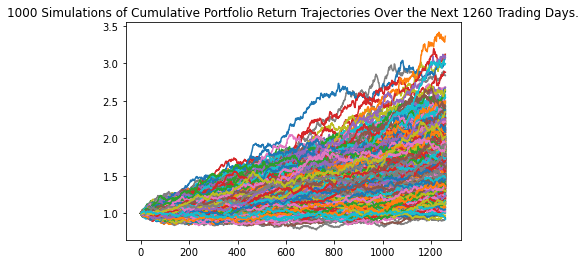

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


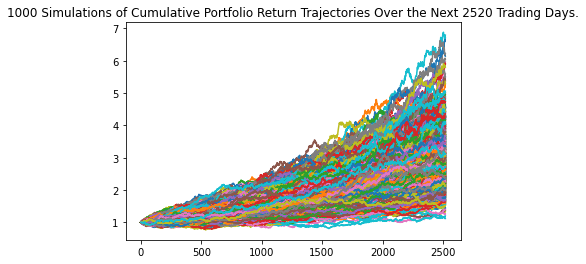

In [21]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

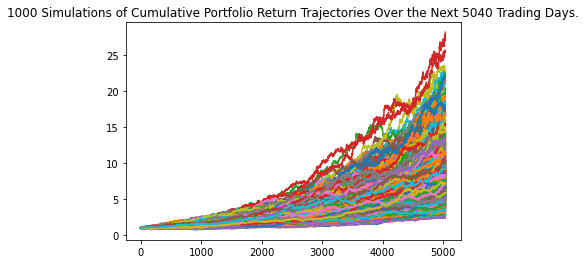

In [22]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario

MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

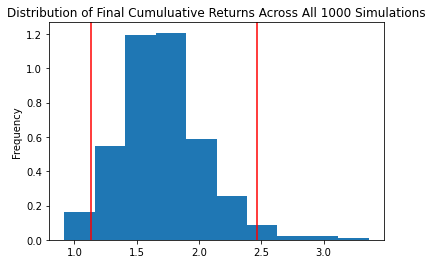

In [23]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()


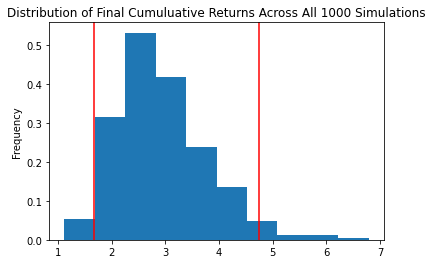

In [24]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()


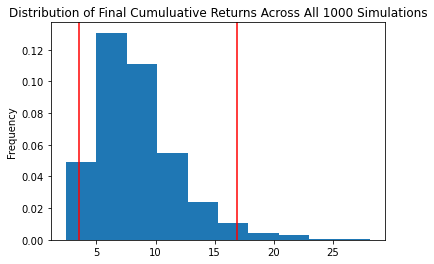

In [25]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [26]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           1000.000000
mean               1.706406
std                0.336813
min                0.918604
25%                1.479784
50%                1.676071
75%                1.889248
max                3.360873
95% CI Lower       1.128664
95% CI Upper       2.465769
Name: 1260, dtype: float64


In [27]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count           1000.000000
mean               2.927953
std                0.840031
min                1.121081
25%                2.328994
50%                2.798074
75%                3.407758
max                6.790561
95% CI Lower       1.668696
95% CI Upper       4.749741
Name: 2520, dtype: float64


In [28]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count           1000.000000
mean               8.435801
std                3.494499
min                2.403768
25%                6.088422
50%                7.826536
75%               10.130733
max               28.174366
95% CI Lower       3.537485
95% CI Upper      16.936593
Name: 5040, dtype: float64


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")


There is a 95% chance that the current value of $1000000.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $1128664.28 and $2465769.18.


In [30]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")


There is a 95% chance that the current value of $1000000.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $1668695.86 and $4749741.07.


In [31]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")


There is a 95% chance that the current value of $1000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $3537484.75 and $16936593.12.


In [49]:
#created dictionary to store values for csv file
client_info_dict = {
    "value of portfolio" : [f"${portfolio_value:.2f}","-","-","-","-"],
    "value per share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
                         f"${value_per_share:.2f}", f"${value_per_share:.2f}"],
    "Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4]],
    "Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}", f"{stock4_shares:.0f}", f"{stock5_shares:.0f}"]    
}  
print(client_info_dict)

{'value of portfolio': ['$1000000.00', '-', '-', '-', '-'], 'value per share': ['$200000.00', '$200000.00', '$200000.00', '$200000.00', '$200000.00'], 'Portfolio Tickers': ['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL'], 'Shares per Ticker': ['1192', '3660', '7468', '3510', '68']}


In [50]:
#created dataframe from dictionary
client_info_df = pd.DataFrame(client_info_dict)
client_info_df.set_index("value of portfolio")

,value per share,Portfolio Tickers,Shares per Ticker
value of portfolio,,,
$1000000.00,$200000.00,JPM,1192
-,$200000.00,VTEB,3660
-,$200000.00,PZA,7468
-,$200000.00,BNDX,3510
-,$200000.00,GOOGL,68


In [34]:
#created csv with dataframe
client_info_df.to_csv("Client Info.csv", index=False)

In [35]:
#created dictionary to turn into a csv file
report_details_dict = {
    "Holding Period" : ["5year", "10year", "20year"],
    "Lower Bound Values" : [f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
                   f"${ci_lower_thirty_cumulative_return_20yr}"],
    "Upper Bound Values" : [f"${ci_upper_thirty_cumulative_return_5yr}",f"${ci_upper_thirty_cumulative_return_10yr}",
                   F"${ci_upper_thirty_cumulative_return_20yr}"]}
                 

In [39]:
#created dataframe with dictionary
report_details_df = pd.DataFrame(report_details_dict)
report_details_df.set_index("Holding Period")

,Lower Bound Values,Upper Bound Values
Holding Period,,
5year,$1128664.28,$2465769.18
10year,$1668695.86,$4749741.07
20year,$3537484.75,$16936593.12


In [38]:
# created csv file with dataframe
report_details_df.to_csv("Report Details.csv", index=False)